# core

> Contains the code that drives the backpropagation algorithm.

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export

# This class stores the Scalar values that we will use that contain the backpropagation information
class Value:
    "This class stores the Scalar values that we will use that contain the backpropagation information"
    def __init__(self, data, _children=(), _op='', label=""):
        self.data = data
        self.grad = 0
        # The children are the values that were used to calculate this value
        self._children = _children
        # The op is the operation that was used to calculate this value
        self._op = _op
        # The backward function is the function that will be used to calculate the gradient
        self._backward = lambda: None
        self.label = label
    
    # Define how operators are used on the Value class

    # Addition
    def __add__(self, other):
        "Define how addition works on the Value class"
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        # Define the backward function
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
    
    # Multiplication
    def __mul__(self, other):
        "Define how multiplication works on the Value class"
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        # Define the backward function
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    # Power
    def __pow__(self, other):
        "Define how power works on the Value class"
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        "Define how the ReLU function works on the Value class"
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    # The Backward function
    def backward(self):
        "Define the backward function"
        # Start with a gradient of 1
        self.grad = 1
        # Topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._children:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        
        # For each node in the topological sort from the end, run the backward function
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [ ]:
show_doc(Value.backward)

---

### Value.backward

>      Value.backward ()

Define the backward function

In [ ]:
show_doc(Value.relu)

---

### Value.relu

>      Value.relu ()

Define how the ReLU function works on the Value class

In [ ]:
#| hide

from IPython.display import Image, display
import graphviz

def draw_dag(v):
    # Create a Digraph object with specific graph attributes
    dot = graphviz.Digraph(format='png', engine='dot', graph_attr={'rankdir': 'LR', 'ranksep': '0.4', 'nodesep': '0.4'})

    # Dictionary to keep track of visited nodes
    visited = {}

    # Recursive function to build the graph
    def build_dot(v):
        if id(v) not in visited:
            visited[id(v)] = v
            # Create a label for the node containing operation, data, and gradient information
            label = f"{v.label}\nOp: {v._op}\nData: {v.data}\nGradient: {v.grad}"
            # Add the node with a rectangular shape
            dot.node(str(id(v)), label=label, shape='box', fontsize='10', width='1.5', height='0.75', margin='0.1')
            for child in v._children:
                # Create edges to child nodes
                dot.edge(str(id(child)), str(id(v)))
                # Recursively build the graph for child nodes
                build_dot(child)
    
    # Call the recursive function to build the graph starting from the given Value
    build_dot(v)

    # Render the graph to a temporary file
    dot.render('dag', view=False)

    # Display the rendered image in the notebook
    display(Image(filename='dag.png'))

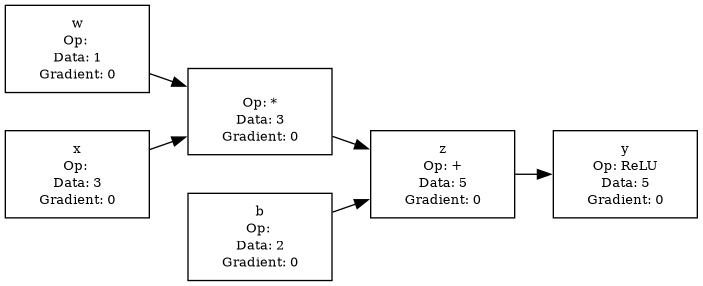

In [ ]:
# Create a temp Value to test the graphviz function
w = Value(1, label="w")
b = Value(2, label="b")
x = Value(3, label="x")
z = w * x + b; z.label = "z"
y = z.relu(); y.label = "y"

# Draw the graphviz DAG
draw_dag(y)

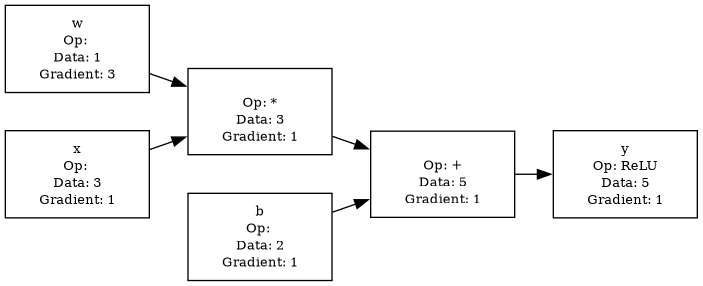

In [ ]:
y.backward()
draw_dag(y)
